In [1]:
import pandas

import seaborn
from matplotlib import pyplot
from IPython.display import Image, display

from pathlib import Path

import json

In [2]:
FILTERED_REAL_SET = 91123
FILTERING_WORKFLOW = 17313 
DATA_LOCATION = Path('../../superwasp-data/')

## Merge subject metadata with CNN scores

In [3]:
zoo_subjects_cache = DATA_LOCATION / 'junk-filtering-cnn-subjects.pkl'
if zoo_subjects_cache.exists():
    zoo_subjects = pandas.read_pickle(zoo_subjects_cache)
else:
    zoo_lookup = pandas.read_csv(
        DATA_LOCATION / 'lookup.dat',
        delim_whitespace=True,
        header=None,
    )
    zoo_lookup.columns = [
        'subject_id',
        'SWASP ID',
        'Period',
        'Period Number',
    ]
    zoo_subjects = pandas.read_csv(
        DATA_LOCATION / 'superwasp-variable-stars-subjects.csv',
    )
    zoo_subjects = zoo_subjects[['subject_id', 'subject_set_id', 'workflow_id', 'retired_at', 'locations']]
    zoo_subjects = zoo_subjects.merge(zoo_lookup)
    zoo_subjects['file'] = zoo_subjects.apply(lambda r: f"{r['SWASP ID']}_P{r['Period Number']}_fold.gif", axis=1)
    zoo_subjects['locations'] = zoo_subjects.apply(lambda r: list(json.loads(r['locations']).values())[0], axis=1)
    zoo_subjects['retired_at'] = pandas.to_datetime(zoo_subjects['retired_at'])
    zoo_subjects.rename({'locations': 'location'}, axis=1, inplace=True)
    zoo_subjects.to_pickle(zoo_subjects_cache)
len(zoo_subjects)

3413060

In [4]:
filtered_real_subjects = zoo_subjects[zoo_subjects['subject_set_id'] == FILTERED_REAL_SET]
retired_subjects = zoo_subjects[(zoo_subjects['workflow_id'] == FILTERING_WORKFLOW) & zoo_subjects['retired_at'].notna()]

In [5]:
cnn_scores = pandas.read_csv(DATA_LOCATION / 'svs-junk-predictions.csv', header=0, names=['file', 'prediction'])
cnn_scores = cnn_scores.merge(zoo_subjects)
cnn_scores = cnn_scores[['file', 'subject_id', 'prediction', 'location']]
cnn_scores.drop_duplicates(inplace=True)
len(cnn_scores)

1569062

In [6]:
cnn_scores_retired = cnn_scores[cnn_scores['subject_id'].isin(retired_subjects['subject_id'])]
cnn_scores_retired['zoo_classification_real'] = cnn_scores_retired['subject_id'].isin(filtered_real_subjects['subject_id'])
len(cnn_scores_retired)

C:\Users\anm83\AppData\Local\Temp/ipykernel_1420/3914798590.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cnn_scores_retired['zoo_classification_real'] = cnn_scores_retired['subject_id'].isin(filtered_real_subjects['subject_id'])


951984

In [7]:
cnn_scores_active = cnn_scores[~cnn_scores['subject_id'].isin(cnn_scores_retired['subject_id'])]
len(cnn_scores_active)

617078

## Plot distribution of scores vs human classifications

<AxesSubplot:xlabel='zoo_classification_real', ylabel='prediction'>

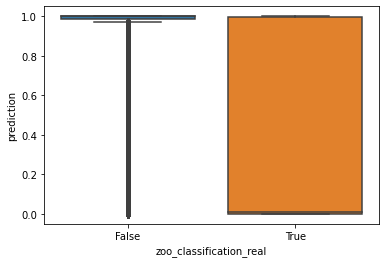

In [8]:
seaborn.boxplot(data=cnn_scores_retired, x='zoo_classification_real', y='prediction')

<AxesSubplot:ylabel='Frequency'>

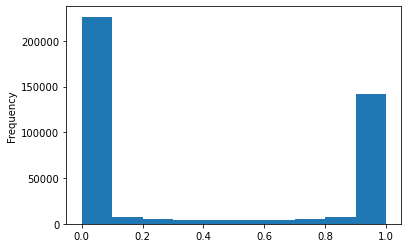

In [9]:
cnn_scores_retired[cnn_scores_retired['zoo_classification_real']]['prediction'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

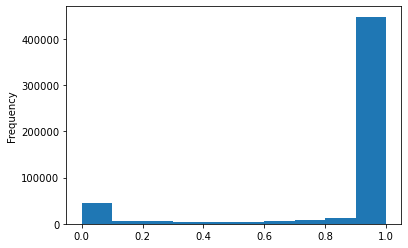

In [10]:
cnn_scores_retired[~cnn_scores_retired['zoo_classification_real']]['prediction'].plot.hist()

## Count classifications

In [11]:
zoo_classifications_cache = DATA_LOCATION / 'junk-filtering-cnn-classifications.pkl'
if zoo_classifications_cache.exists():
    zoo_classifications = pandas.read_pickle(zoo_classifications_cache)
else:
    zoo_classifications = pandas.read_csv(
        DATA_LOCATION / 'superwasp-variable-stars-classifications.csv',
    )
    zoo_classifications = zoo_classifications[zoo_classifications['workflow_id'] == FILTERING_WORKFLOW]
    zoo_classifications.rename({'subject_ids': 'subject_id'}, axis=1, inplace=True)
    zoo_classifications['created_at'] = pandas.to_datetime(zoo_classifications['created_at'])
    zoo_classifications.to_pickle(zoo_classifications_cache)
zoo_classifications.drop_duplicates(subset=['user_name', 'subject_id'], inplace=True)
zoo_classifications = zoo_classifications.merge(retired_subjects[['subject_id', 'retired_at']]).drop_duplicates()
zoo_classifications = zoo_classifications[zoo_classifications['created_at'] <= zoo_classifications['retired_at']]

In [12]:
classification_counts = pandas.pivot_table(
    zoo_classifications,
    values='classification_id',
    aggfunc=len,
    index='subject_id',
)
classification_counts.rename({'classification_id': 'classification_count'}, axis=1, inplace=True)
classification_counts.reset_index(inplace=True)

<AxesSubplot:ylabel='Frequency'>

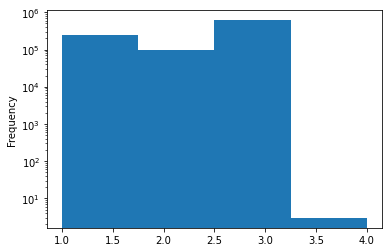

In [13]:
classification_counts['classification_count'].plot.hist(logy=True, bins=max(classification_counts['classification_count']))

# Plot sample of misclassified subjects

In [14]:
misclassified_real_as_junk = cnn_scores_retired[cnn_scores_retired['zoo_classification_real'] & (cnn_scores_retired['prediction'] > 0.5)]
misclassified_real_as_junk = misclassified_real_as_junk.merge(classification_counts)
misclassified_real_as_junk

,file,subject_id,prediction,location,zoo_classification_real,classification_count
0,1SWASPJ191851.17-181611.2_P1_fold.gif,23680962,1.000000,https://panoptes-uploads.zooniverse.org/subjec...,True,1
1,1SWASPJ193134.23-204007.3_P1_fold.gif,23727327,0.999987,https://panoptes-uploads.zooniverse.org/subjec...,True,1
2,1SWASPJ192637.84-191505.6_P3_fold.gif,23701332,0.658785,https://panoptes-uploads.zooniverse.org/subjec...,True,3
3,1SWASPJ193206.03+514729.8_P3_fold.gif,23732167,0.999991,https://panoptes-uploads.zooniverse.org/subjec...,True,1
4,1SWASPJ192819.14-101839.7_P3_fold.gif,23707606,0.990684,https://panoptes-uploads.zooniverse.org/subjec...,True,2
...,...,...,...,...,...,...
163119,1SWASPJ203444.63+063744.9_P1_fold.gif,24048083,0.995545,https://panoptes-uploads.zooniverse.org/subjec...,True,2
163120,1SWASPJ203054.11+052207.7_P1_fold.gif,24028608,0.980465,https://panoptes-uploads.zooniverse.org/subjec...,True,1
163121,1SWASPJ204039.25-495734.5_P1_fold.gif,24060619,0.999885,https://panoptes-uploads.zooniverse.org/subjec...,True,1
163122,1SWASPJ205254.57+014844.0_P1_fold.gif,24812174,0.863901,https://panoptes-uploads.zooniverse.org/subjec...,True,1


In [15]:
for classification_count in range(1, 4):
    print('Classification count: ', classification_count)
    for url in misclassified_real_as_junk[misclassified_real_as_junk['classification_count'] == classification_count].head(10)['location']:
        display(Image(url=url))

Classification count:  1


Classification count:  2


Classification count:  3


### Distribution of scores for active subjects

<AxesSubplot:ylabel='Frequency'>

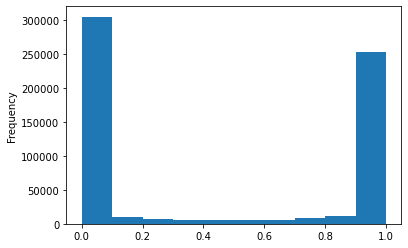

In [16]:
cnn_scores_active['prediction'].plot.hist()

### Sample light curves of active subjects

In [17]:
REAL_THRESHOLD = 0.1
JUNK_THRESHOLD = 0.9

#### Real

In [18]:
active_real = cnn_scores_active[cnn_scores_active['prediction'] < REAL_THRESHOLD]
display(len(active_real))
for url in active_real.head(10)['location']:
    display(Image(url=url))

305337

#### Junk

In [19]:
active_junk = cnn_scores_active[cnn_scores_active['prediction'] >= JUNK_THRESHOLD]
display(len(active_junk))
for url in active_junk.head(10)['location']:
    display(Image(url=url))

252613

#### In the middle

In [20]:
active_middle = cnn_scores_active[(cnn_scores_active['prediction'] >= REAL_THRESHOLD) & (cnn_scores_active['prediction'] < JUNK_THRESHOLD)]
display(len(active_middle))
for url in active_middle.head(10)['location']:
    display(Image(url=url))

59128